# **Sentiment Analysis using Python**

### **Import Libraries and Setup**

In [ ]:
import pandas as pd
import numpy as np
import re
import contractions
from tqdm import tqdm
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# --- NLTK Setup ---
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

# --- Scikit-learn ---
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline


# --- Utility ---
import joblib  # For saving the model
warnings.filterwarnings('ignore')
tqdm.pandas()

# --- Initialize Core Components ---
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\diana\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### **Load and Explore the Data**

In [3]:
data = pd.read_csv('IMDB Dataset.csv')

# --- Initial Exploration ---
print("--- First 5 Rows ---")
display(data.head())

print("\n--- Data Info ---")
data.info()

# --- Handle Duplicates ---
print(f"\nOriginal shape: {data.shape}")
data.drop_duplicates(inplace=True)
print(f"Shape after dropping duplicates: {data.shape}")

# --- Convert sentiment to numerical format ---
data['sentiment'] = data['sentiment'].replace({'positive': 1, 'negative': 0})
print("\n--- Sample after converting sentiment to numeric ---")
display(data.sample(3))

--- First 5 Rows ---


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive



--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB

Original shape: (50000, 2)
Shape after dropping duplicates: (49582, 2)

--- Sample after converting sentiment to numeric ---


,review,sentiment
7340,This film was amazing. It had an original conc...,1
49332,A young ( only 21 ) director with great talent...,1
36402,This may be the only film that actually comes ...,1


## **Visualize Sentiment Distribution**

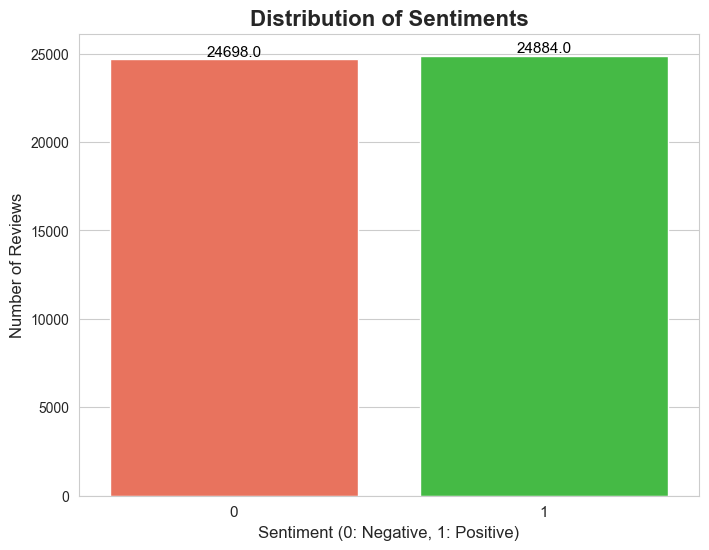

In [4]:
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
ax = sns.countplot(x='sentiment', data=data, palette=['#FF6347', '#32CD32']) # Red for negative, Green for positive
plt.title('Distribution of Sentiments', fontsize=16, weight='bold')
plt.xlabel('Sentiment (0: Negative, 1: Positive)', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(fontsize=11)

# Add annotations
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.show()

## **Data Preprocessing**

In [5]:
def data_cleaning(text):
  """
  Cleans the input text by:
  1. Converting to lowercase.
  2. Expanding contractions (e.g., "I'm" to "I am").
  3. Removing HTML tags.
  4. Removing URLs.
  5. Removing non-alphanumeric characters (keeps only letters and numbers).
  6. Tokenizing the text.
  7. Removing stopwords while keeping important negation words.
  8. Lemmatizing tokens to their base form.
  """
  # Lowercase the text
  text = text.lower()
  # Expand contractions
  text = contractions.fix(text)
  # Remove HTML tags
  text = re.sub(r'<.*?>', '', text)
  # Remove URLs
  text = re.sub(r'https?://\S+|www\.\S+', '', text)
  # Remove non-alphanumeric characters
  text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
  # Tokenization
  tokens = word_tokenize(text)
  # Define negation words to keep
  negation_words = {'not', 'no', 'never', 'ain\'t'}
  # Filter out stopwords but keep negation words
  filtered_tokens = [word for word in tokens if word not in stop_words or word in negation_words]
  # Lemmatization
  lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
  # Join tokens back into a string
  return " ".join(lemmatized_tokens)

# Apply the cleaning function with a progress bar
data['cleaned_review'] = data['review'].progress_apply(data_cleaning)

print("--- Sample of Original vs. Cleaned Reviews ---")
display(data[['review', 'cleaned_review']].sample(3))

100%|██████████| 49582/49582 [01:53<00:00, 436.91it/s]

--- Sample of Original vs. Cleaned Reviews ---


,review,cleaned_review
21606,Jonathan Demme is such a character-oriented di...,jonathan demme characteroriented director see ...
28503,Nobody said movies had to be realistic did the...,nobody said movie realistic really liked movie...
44046,"The title should have been ""The walker"". That ...",title walker walkthere nothing movie good desc...


## **Word Cloud Visualizations**

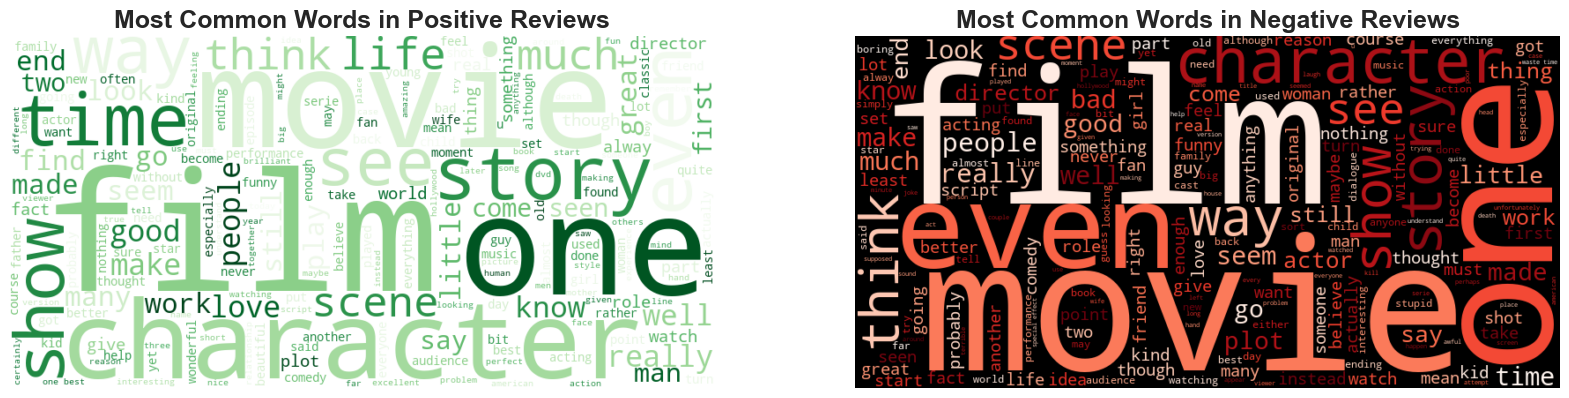

In [6]:
positive_text = " ".join(data[data['sentiment'] == 1]['cleaned_review'])
negative_text = " ".join(data[data['sentiment'] == 0]['cleaned_review'])

# Positive Word Cloud
positive_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_text)

# Negative Word Cloud
negative_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_text)

# Plotting the word clouds
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Most Common Words in Positive Reviews', fontsize=18, weight='bold')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Most Common Words in Negative Reviews', fontsize=18, weight='bold')
plt.axis('off')

plt.show()

## **Model Evaluation**

In [ ]:
# --- STEP 1: PERFORM A CLEAN TRAIN-TEST SPLIT ---
X = data['cleaned_review']
y = data['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


# --- STEP 2: DEFINE THE PIPELINE AND AN OPTIMIZED PARAMETER GRID ---
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC(random_state=42, dual=False)),
])

# Define the settings for GridSearchCV to test.
parameters = {
    # Test with unigrams and bigrams
    'tfidf__ngram_range': [(1, 1), (1, 2)],

    # Test with different vocabulary sizes.
    # It will try using the top 50,000 features, and then all features (None).
    # This prevents the matrix from getting too large.
    'tfidf__max_features': [50000, None],

    # Test with different regularization strengths
    'clf__C': [0.1, 1, 10],
}


# --- STEP 3: CREATE AND RUN THE GRIDSEARCH ---
grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=2)

print("Starting the optimized search for the best ML model. This will take several minutes...")
grid_search.fit(X_train, y_train)


# --- STEP 4: DISPLAY THE RESULTS OF THE SEARCH ---
print("\n----------------------------------------------------")
print("GridSearchCV has finished.")
print("The best cross-validation accuracy score found on the training data is: %0.4f" % grid_search.best_score_)
print("\nThe best parameters that achieved this score are:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
print("----------------------------------------------------")


# --- STEP 5: FINAL EVALUATION ON THE UNSEEN TEST SET ---
print("\n--- Final Performance Report on the Held-Out Test Set ---")
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


# --- STEP 6: (OPTIONAL) SAVE THE NEW, SUPERIOR MODEL ---
joblib.dump(best_model, 'best_ml_model.pkl')
print("\nBest model has been saved to 'best_ml_model.pkl'")

Starting the optimized search for the best ML model. This will take several minutes...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

----------------------------------------------------
GridSearchCV has finished.
The best cross-validation accuracy score found on the training data is: 0.9072

The best parameters that achieved this score are:
	clf__C: 10
	tfidf__max_features: None
	tfidf__ngram_range: (1, 2)
----------------------------------------------------

--- Final Performance Report on the Held-Out Test Set ---
              precision    recall  f1-score   support

    Negative       0.92      0.90      0.91      4940
    Positive       0.90      0.92      0.91      4977

    accuracy                           0.91      9917
   macro avg       0.91      0.91      0.91      9917
weighted avg       0.91      0.91      0.91      9917


Best model has been saved to 'best_ml_model.pkl'


## **Create Prediction Function**

In [ ]:
def predict_sentiment(review_text):
  """
  Predicts the sentiment of a single review text using our best-found model.
  """
  # The `best_model` object is a full pipeline. It handles vectorizing and predicting.
  # We just need to pass the cleaned text to it.
  prediction = best_model.predict([review_text])

  # Return the human-readable result
  return "Positive" if prediction[0] == 1 else "Negative"

## **Interactive Prediction**

In [ ]:
joblib.dump(best_model, 'best_ml_model.pkl')

print("The best performing model has been saved successfully as 'best_ml_model.pkl'")

The best performing model has been saved successfully as 'best_ml_model.pkl'
